# Compressibility from Molecular Dynamics Simulations of Lennard-Jones systems

Ralf Everaers, ENS Lyon (2022)

The compressibility can be inferred from fluctuations of the virial pressure:

\begin{equation}
\langle \delta {\cal P}^2 \rangle_{NVT} = \frac{k_BT}{V} \left( \frac{2 N k_BT}{d V} +  \langle {\cal P} \rangle_{NVT} -\beta_T^{-1}  + \frac1V \langle {\cal X} \rangle_{NVT} \right)
\end{equation}

where
\begin{equation}
{\cal P} 
= \frac1{d V} \left[ \sum_i m_i \left|\vec v_i \right|^2 
                    + \sum_{i<j} \vec f_{ij}\cdot\vec r_{ij} \right]
\end{equation}

Alternatively one can define the pressure as
\begin{equation}
{\cal P'} 
= \rho k_BT + \frac1{d V} \left[  \sum_{i<j} \vec f_{ij}\cdot\vec r_{ij} \right]
= \rho k_BT + \frac1{V} \langle {\cal W} \rangle
\end{equation}

In this case 

\begin{equation}
\langle \delta {\cal P'}^2 \rangle_{NVT} = \frac{k_BT}{V} \left( \langle {\cal P'} \rangle_{NVT} -\beta_T^{-1}  + \frac1V \langle {\cal X} \rangle_{NVT} \right)
\end{equation}


Reference:

    M. Allen and D. Tildesley, Computer Simulations of Liquids, 2nd Edition, Oxford (2017), pp. 60-69

In [5]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

## A routine for generating or extending individual NVT-MD trajectories for a LJ systems

In [3]:
def Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                 starting_configuration=[],
                                                 time_step = 0.01,
                                                 number_of_time_steps_between_stored_configurations=100,
                                                 number_of_time_steps_between_velocity_resets=100,
                                                 debug=False):
    """
    generates a NVT MD simulations of a LJ system with sigma=epsilon=1  
        - where the particle masses are specified in the array m
        - so that NParticles = m.size
        - in a volume V=(LBox,LBox) at a specified temperature kT
        - with a time step of time_step tau 
          where the LJ unit of time is calculated as a function of m[-1], i.e. the mass of the LAST particle
        - runs are either started from 
                a specified starting configuration [t,x,y,vx,vy] or
                initialized with zero velocities and particles placed on a square grid
        - the simulations are thermostated by redrawing random velocities from the 
          Maxwell-Boltzmann distribution number_of_time_steps_between_velocity_resets time steps
        - the function returns 
                trajectory lists t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr 
                     of sampling times and sampled coordinates, velocities and energies and pressures
                a final configuration [t,x,y,vx,vy] from which the run can be restarted
                while the energies and pressures are recorded at every time step, configurations 
                     and velocities are stored at a time interval of time_between_stored_configurations
                    
    """

    NParticles = m.size
    sigma = 1
    epsilon = 1
    #unit of time
    tau = sigma*np.sqrt(m[-1]/epsilon)      

    # define the length of the trajectory
    number_of_timesteps = int(np.round(run_time/time_step))

    #starting configuration
    if starting_configuration!=[]:
        [t,x,y,vx,vy] = starting_configuration
    else:
        # default initial state
        x,y = MD.GridPositionsIn2d(LBox,LBox,NParticles)
        vx = MD.RandomVelocities(m,kT)
        vy = MD.RandomVelocities(m,kT)
        t = 0
        if debug:
            print("No starting configuration")

    #initialize Trajectory
    t_tr = []
    x_tr = []
    vx_tr = []
    y_tr = []
    vy_tr = []

    fx,fy = MD.LJ_forces_as_a_function_of_positions(d,epsilon,sigma,LBox,(x,y))
    # force for initial configuration needed for first time step

    for timestep in range(number_of_timesteps):
        (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartOne(m,(x,y),(vx,vy),(fx,fy),time_step)
        fx,fy = MD.LJ_forces_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
        (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartTwo(m,(x,y),(vx,vy),(fx,fy),time_step)
        t += time_step
        
        t_tr.append(t)
        x_tr.append(x)
        vx_tr.append(vx)
        y_tr.append(y)
        vy_tr.append(vy)
    
        # thermostat: reinitialise velocities to control temperature
#        if np.mod( timestep*time_step, time_between_velocity_resets ) == 0.0 and timestep>1:
        if timestep%number_of_time_steps_between_velocity_resets == 0 and timestep>1:
            vx = MD.RandomVelocities(m,kT)
            vy = MD.RandomVelocities(m,kT)

    # convert trajectory lists to arrays to simplify the data analysis
    t_tr = np.array(t_tr)
    x_tr = np.array(x_tr)
    vx_tr = np.array(vx_tr)
    y_tr = np.array(y_tr)
    vy_tr = np.array(vy_tr)

    # analyse results 
    uPot_tr = MD.LJ_energy_as_a_function_of_positions(d,epsilon,sigma,LBox,(x_tr,y_tr))
    uKin_tr = MD.TotalKineticEnergy(m,vx_tr) + MD.TotalKineticEnergy(m,vy_tr)
    pPot_tr = MD.LJ_virial_pressure_as_a_function_of_positions(d,epsilon,sigma,LBox,(x_tr,y_tr)) 
    pKin_tr = MD.KineticPressure_as_a_function_of_velocities(d,LBox,m,(vx_tr,vy_tr))
    pHyper_tr = MD.LJ_hyper_virial_as_a_function_of_positions(d,epsilon,sigma,LBox,(x_tr,y_tr)) 
    
    # reduce the number of stored configurations and velocities
#    skip = int(time_between_stored_configurations / delta_t)
    skip = number_of_time_steps_between_stored_configurations
    x_tr = x_tr[::skip]
    y_tr = y_tr[::skip]
    vx_tr = vx_tr[::skip]
    vy_tr = vy_tr[::skip]    
    # note that t_tr is not compressed as it contains the times corresponding to the stored energies and pressures
    # as a consequence a corresponding skipping operation needs to be performed, when configurations are plotted 
    # as a function of time
    
    return t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, pHyper_tr, [t,x,y,vx,vy]

## A first trajectory for a 2d LJ system

In [20]:
# define system
d=2
NParticles=64
kT = 0.4
m = np.ones(NParticles)

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time     

# choose density
rho = 0.5/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 200. * tau

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

( t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, pHyper_tr, [t,x,y,vx,vy] 
) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  11.313708499
Execution time:  58.14187620813027


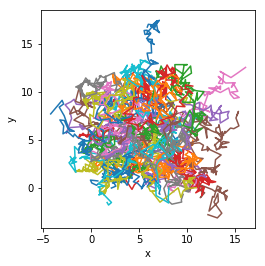

In [7]:
ax = plt.axes()
MD.AddParticleTraces(ax,x_tr,y_tr,range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

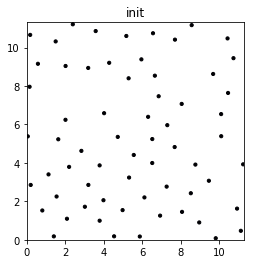

In [8]:
skip=10
MD.AnimateMDRun(t_tr[::skip],x_tr[::skip],y_tr[::skip],xBox=(0,LBox),yBox=(0,LBox),xpbc=True,ypbc=True,m=m)

## Compressibility

The compressibility can be inferred from fluctuations of the virial pressure:

\begin{equation}
\langle \delta {\cal P}^2 \rangle_{NVT} = \frac{k_BT}{V} \left( \frac{2 N k_BT}{d V} +  \langle {\cal P} \rangle_{NVT} -\beta_T^{-1}  + \frac1V \langle {\cal X} \rangle_{NVT} \right)
\end{equation}

where
\begin{equation}
{\cal P} 
= \frac1{d V} \left[ \sum_i m_i \left|\vec v_i \right|^2 
                    + \sum_{i<j} \vec f_{ij}\cdot\vec r_{ij} \right]
\end{equation}

Alternatively one can define the pressure as
\begin{equation}
{\cal P'} 
= \rho k_BT + \frac1{d V} \left[  \sum_{i<j} \vec f_{ij}\cdot\vec r_{ij} \right]
= \rho k_BT + \frac1{V} \langle {\cal W} \rangle
\end{equation}

In this case 

\begin{equation}
\langle \delta {\cal P'}^2 \rangle_{NVT} = \frac{k_BT}{V} \left( \langle {\cal P'} \rangle_{NVT} -\beta_T^{-1}  + \frac1V \langle {\cal X} \rangle_{NVT} \right)
\end{equation}


Reference:

    M. Allen and D. Tildesley, Computer Simulations of Liquids, 2nd Edition, Oxford (2017), pp. 60-69

Solving the above relations for the compressibility yields

\begin{equation}
\beta_T^{-1} 
 =  \frac{2 N k_BT}{d V} - \frac{V}{k_BT} \langle \delta {\cal P}^2 \rangle_{NVT} +  \langle {\cal P} \rangle_{NVT}   + \frac1V \langle {\cal X} \rangle_{NVT} 
\end{equation}

and

\begin{equation}
\beta_T^{-1} 
 =   - \frac{V}{k_BT} \langle \delta {\cal P'}^2 \rangle_{NVT} +  \langle {\cal P'} \rangle_{NVT}   + \frac1V \langle {\cal X} \rangle_{NVT} 
\end{equation}


In [9]:
np.arange(10)==0

array([ True, False, False, False, False, False, False, False, False, False], dtype=bool)

In [11]:
p=np.arange(10)
isinstance(p,(list,np.ndarray))

True

In [14]:
def Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot, pHyper, pKin=0):
    """
    Returns an estimate of the compressibility based on the analysis of the fluctuations of 
    the virial pressure in the canonical ensemble
    """
    if isinstance(pKin,np.ndarray):
        one_over_beta_T = 2*NParticles*kT/d/LBox**d - np.var(pPot+pKin)*LBox**d/kT + np.mean(pPot+pKin+pHyper)
    else:
        one_over_beta_T =                           - np.var(pPot     )*LBox**d/kT + np.mean(pPot     +pHyper)
        
    return 1/one_over_beta_T

In [28]:
def Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot, pHyper, pKin=0):
    """
    Returns an estimate of the compressibility based on the analysis of the fluctuations of 
    the virial pressure in the canonical ensemble
    """
    if isinstance(pKin,np.ndarray):
        beta_T = 1./( 2*NParticles*kT/d/LBox**d - np.var(pPot+pKin,axis=-1)*LBox**d/kT + np.mean(pPot+pKin+pHyper,axis=-1) )
    else:
        beta_T = 1./(                           - np.var(pPot     ,axis=-1)*LBox**d/kT + np.mean(pPot     +pHyper,axis=-1) )
        
    if pPot.ndim==1:
        # data for one trajectories
        return beta_T
    elif pPot.ndim==2:
        # data for an ensemble of trajectories
        NTrajectories = beta_T.size
        return np.mean(beta_T), np.std(beta_T)/np.sqrt(NTrajectories)

Test for data from one trajectory

In [30]:
Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot_tr, pHyper_tr, pKin_tr)

-2.8936968994630918

In [31]:
Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot_tr, pHyper_tr)

-1.4129035563275876

Test for data from fake ensemble of trajectories

In [32]:
Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,
                                                  np.array([pPot_tr,pPot_tr,pPot_tr]), 
                                                  np.array([pHyper_tr,pHyper_tr,pHyper_tr]), 
                                                  np.array([pKin_tr,pKin_tr,pKin_tr])
                                                 )

(-2.8936968994630923, 2.5639502485114189e-16)

In [33]:
Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,
                                                  np.array([pPot_tr,pPot_tr,pPot_tr]), 
                                                  np.array([pHyper_tr,pHyper_tr,pHyper_tr])
                                                 )

(-1.4129035563275876, 0.0)

# Old

In [6]:
def MeanSquareDisplacements(t_tr,x_tr):
    """
    Returns the particle and time average mean-square displacement < (x(t)-x(0))**2 > 
    in one Cartesian direction for a trajectory of x- or y-positions
    """
    
    NParticles = x_tr.shape[-1]
    length_of_x_tr = x_tr.shape[-2]
    length_of_t_tr = t_tr.shape[-1]
    local_x_tr = np.copy(x_tr)

    if x_tr.ndim>2:
        # data for an ensemble of trajectories
        NTrajectories = x_tr.shape[-3]
        local_x_tr = local_x_tr.transpose(1,0,2)
        # so that the time axis is always the first axis (or rather axis=0)
    else:
        NTrajectories = 1
        
    msd = []
    delta_t = []
    
    for n in range(1,length_of_x_tr//2):
        
        n_t = n*length_of_t_tr//length_of_x_tr  # because sometimes configurations are not stored for each time step
        if t_tr.ndim==1:
            # data for one trajectories
            delta_t.append(t_tr[n_t]-t_tr[0])
        elif t_tr.ndim==2:
            # data for an ensemble of trajectories
            delta_t.append(t_tr[0,n_t]-t_tr[0,0])
        delta_x2 = ( local_x_tr - np.roll(local_x_tr,-n,axis=0) )**2
        msd.append(np.mean(delta_x2[:length_of_x_tr-n]))
        
    return np.array(delta_t), np.array(msd)

In [7]:
delta_t, x_msd = MeanSquareDisplacements(t_tr,x_tr)

In [8]:
delta_t, y_msd = MeanSquareDisplacements(t_tr,y_tr)

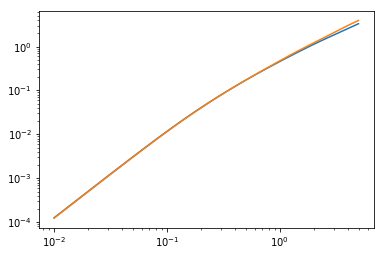

In [9]:
plt.loglog(delta_t,x_msd)
plt.loglog(delta_t,y_msd)

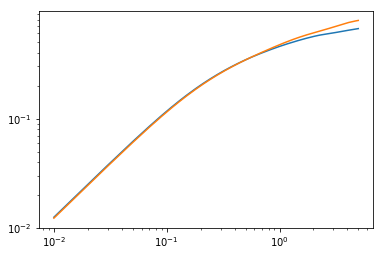

In [10]:
plt.loglog(delta_t,x_msd/delta_t)
plt.loglog(delta_t,y_msd/delta_t)

Test that the function also works for an ensemble

In [11]:
delta_t, xx_msd = MeanSquareDisplacements(np.array([t_tr,t_tr,t_tr]),np.array([x_tr,x_tr,x_tr]))

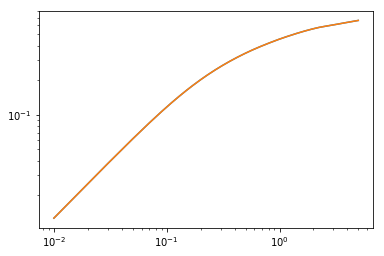

In [12]:
plt.loglog(delta_t,x_msd/delta_t)
plt.loglog(delta_t,xx_msd/delta_t)